In [1]:
##### base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# matplotlib
%matplotlib inline

# display
from IPython.display import display

# autoreload
%load_ext autoreload
%autoreload 2

# warnings
import warnings
warnings.filterwarnings('ignore')

# fix random seed
from numpy.random import seed as set_random_seed
set_random_seed(42)


# debug
from icecream import ic
debug = ic


In [2]:
from data_extraction.articles import get_articles
articles_processed = get_articles(processed=True)
articles_processed.sample().iloc[0]
for col in articles_processed.columns:
    articles_processed = articles_processed[articles_processed[col].str.len() > 0]
from spacy.lang.he.stop_words import STOP_WORDS
STOP_WORDS.update(',')
from feature_extraction.article import tokenize_article
articles = articles_processed.apply(tokenize_article, axis = 1, args = [[STOP_WORDS]])
raw_articles = get_articles()

data = pd.merge(
    articles,
    raw_articles,
    right_index = True,
    left_index = True,
    how = 'inner',
    suffixes= ('', '_raw')
)
#TODO: remove '?'

In [3]:
from utils.metric_utils import jaccard_score, bleu, rouge

def check_score(r, score = jaccard_score, *score_args, **score_kwargs):
    summary = r['summary_tokens']
    sub_title = r['sub_title']
    return score(sub_title[0], summary, *score_args, **score_kwargs)
# scores = data.apply(check_score, axis = 1, args = (bleu, 1))
# data['score'] = scores

In [4]:
test = data.sample(50)

In [5]:
from models.nlp.summarization.textrank import TextRankModel
from models.nlp.summarization.firstk import  FirstKModel
from scipy.special import expit


In [6]:
def compare_models(models: dict, metrics: dict, train, test, fit = False, plot = False):
    summaries_pred = {}
    scores_table = {}
    for model_name, model in models.items():
        if fit:
            model.fit(
                train['content'],
                train['content_raw'],
                y = train['sub_title'].apply(lambda l: l[0]),
            )
        summaries_pred[model_name] = model.predict(
            test['content'],
            test['content_raw']
        )
        scores_table[model_name] = {}
    for metric_name, metric_args in metrics.items():
        for model_name, model in models.items():
            data = test.copy(deep=True)
            data = pd.merge(
                data,
                summaries_pred[model_name],
                right_index = True,
                left_index = True,
                how = 'inner',
                suffixes= ('', '')
            )
            scores = data.apply(check_score, axis = 1, args = metric_args)
            score_mean = np.round(scores.mean(), 2)
            if plot:
                plt.hist(scores, label = f'{model_name}: {score_mean}', alpha = 1.5 * (1/len(models.keys())))
            scores_table[model_name][metric_name] = score_mean
        if plot:
            plt.title(f'Hisogram for {metric_name} score')
            plt.legend()
            plt.show()
    return pd.DataFrame(scores_table)

In [13]:
i = 0
N = 1
t = TextRankModel(STOP_WORDS, N=N)
s = t.predict(test['content'],test['content_raw'])
for ssum in s['summary']:
    print(ssum)
t = TextRankModel(STOP_WORDS,'word2vec',N=N)
s = t.predict(test['content'],test['content_raw'])
for ssum in s['summary']:
    print(ssum)
t = TextRankModel(STOP_WORDS,'word2vec',lambda x: pow(x,5),N=N)
s = t.predict(test['content'],test['content_raw'],N=N)
for ssum in s['summary']:
    print(ssum)

  0%|          | 0/50 [00:00<?, ?it/s]

[2]
[10]
[27]
[0]
[3]
[13]
[1]
[14]
[4]
[0]
[3]
[34]
[8]
[2]
[18]
[39]
[1]
[1]
[17]
[0]
[14]
[25]
[11]
[5]
[1]
[0]
[27]
[0]
[0]
[6]
[4]
[1]
[0]
[2]
[21]
[6]
[0]
[23]
[18]
[4]
[0]
[13]
[21]
[4]
[0]
[16]
[5]
[0]
[18]
[20]
[' לבנת אמרה להם כי "\u202cהמדינה\u202e \u202cצריכה\u202e \u202cלהעניק\u202e \u202cהעדפה\u202e \u202cמתקנת\u202e \u202cלאוכלוסיית\u202e \u202cהמפונים\u202e"']
['        ח"כ מיקי זוהר התייחס לדבריו של נתניהו בנוגע לחוק: "הנוסח הסופי של החוק מצוין ואני בטוח שראש הממשלה יתמוך בו']
[' עמותת עובדי השוק, שפעלו כדי להביא את אנשי העבודה לשוק, מבטיחים לפרס כי אם אחד מהם יתקבל למרכז העבודה, הם יהפכו אותו לראש ממשלה']
['הנגבי פרש, נתניהו משדר עסקים כרגיל: במהלך מסיבת העיתונאים שכינסו היום (ד\') בנימין נתניהו ועוזי לנדאו בבית סוקולוב אמר נתניהו כי "מנהיגי הליכוד סטו מדרכו של הליכוד']
[' כך הגיב הבוקר (ב\') ח"כ באסל גטאס (הרשימה המשותפת), שהודיע שיעלה על המשט שייצא מיוון לכיוון רצועת עזה']
['   בכיר במפלגה אף כינה את נסיונות המחאה של השרים "מרד תרנגולים" ואמר: "אין שום מרד']
['     

  0%|          | 0/50 [00:00<?, ?it/s]

[4]
[17]
[8]
[30]
[10]
[7]
[24]
[34]
[0]
[1]
[0]
[34]
[9]
[10]
[8]
[39]
[15]
[3]
[25]
[3]
[29]
[16]
[18]
[11]
[2]
[12]
[17]
[1]
[3]
[12]
[4]
[10]
[12]
[16]
[32]
[8]
[30]
[1]
[2]
[41]
[2]
[30]
[17]
[34]
[10]
[16]
[0]
[0]
[3]
[0]
['    במכתב ששלח ראש המועצה האזורית לכיש, דני מורבייה, למנכ"ל משרד ראש הממשלה, אייל גבאי, נכתב כי "\u202cבהתאם\u202e \u202cלקצב\u202e \u202cעבודות\u202e \u202cהפיתוח\u202e \u202cהמתבצעות\u202e \u202cכיום\u202e \u202cבשטח\u202e, \u202cהצפי\u202e \u202cלמסירת\u202e \u202cהמגרשים\u202e \u202cלבנייה\u202e \u202cהינו\u202e \u202cבחודש\u202e \u202cאפריל\u202e 2010, \u202cאסור\u202e \u202cוחטא\u202e \u202cיהיה\u202e \u202cהדבר\u202e \u202cאם\u202e \u202cיעמדו\u202e \u202cמגרשים\u202e \u202cמוכנים\u202e \u202cומפותחים\u202e \u202cלבנייה\u202e \u202cאולם\u202e \u202cהמתיישבים\u202e \u202cלא\u202e \u202cיוכלו\u202e \u202cלהיכנס\u202e \u202cלביתם\u202e \u202cהחדש\u202e \u202cבשל\u202e \u202cמחסור\u202e \u202cבמוסדות\u202e \u202cחינוך\u202e \u202cוציבור\u202e"']
['   מועלם 

  0%|          | 0/50 [00:00<?, ?it/s]

[3]
[10]
[8]
[0]
[10]
[18]
[1]
[14]
[4]
[0]
[2]
[2]
[8]
[3]
[0]
[39]
[1]
[1]
[32]
[3]
[14]
[13]
[11]
[5]
[2]
[0]
[27]
[5]
[0]
[9]
[4]
[1]
[0]
[2]
[21]
[6]
[0]
[21]
[18]
[4]
[4]
[31]
[21]
[8]
[0]
[16]
[5]
[0]
[18]
[20]
['   ממסמך שהגיע למערכת ynet עולה כי הפערים בתקציבים שהוקצו על-ידי הממשלה עבור יישובי הקבע של המפונים לבין הצרכים בשטח גדולים מאוד']
['        ח"כ מיקי זוהר התייחס לדבריו של נתניהו בנוגע לחוק: "הנוסח הסופי של החוק מצוין ואני בטוח שראש הממשלה יתמוך בו']
[' פרס לא מפספס את השאלה, מפנה את ראשו לעבר השואל, וצועק לעברו: "אתם תצילו אותנו, ואנחנו נציל אתכם", הוא אומר, אבל המוכר לא משתכנע']
['הנגבי פרש, נתניהו משדר עסקים כרגיל: במהלך מסיבת העיתונאים שכינסו היום (ד\') בנימין נתניהו ועוזי לנדאו בבית סוקולוב אמר נתניהו כי "מנהיגי הליכוד סטו מדרכו של הליכוד']
['    גטאס ציין שוב שמדובר במשט שמביא עמו ציוד רפואי לבתי חולים בעזה, והזהיר מפני התערבות ישראלית']
[' כבל הדגיש כי הסיעה כולה מאוחדת בשלב זה מאחורי עמיר פרץ ומדיניותו להוצאת העבודה מן הממשלה']
['      בישיבת סיעתו "ישראל ביתנו"

In [27]:
test = test.sample(10)
len(test)

10

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

ic| intersection: {',',
                   'אדלשטיין',
                   'הכנסת',
                   'חקיקה',
                   'יו',
                   'יולי',
                   'יריב',
                   'כנסת',
                   'לוין',
                   'ממשלה',
                   'משפטים',
                   'על',
                   'פיקוח',
                   'שקד',
                   'שר',
                   'שרת'}
ic| len(union): 43
ic| intersection: {'נירנברג', 'ליברמן', ',', 'יו'}
ic| len(union): 58
ic| intersection: {'רשות', 'שידור', 'את', 'צריך', 'של', 'שר', ',', 'אנשים', 'תקשורת'}
ic| len(union): 39
ic| intersection: {'משפטים', 'משרד', 'שימוש', ',', 'אינו', 'מוצדק'}
ic| len(union): 45
ic| intersection: {'כי', 'אברהם', 'רב', 'שפירא'}
ic| len(union): 40
ic| intersection: {',',
                   'דו',
                   'היום',
                   'יישום',
                   'כבאות',
                   'לבנון',
                   'לקחי',
                   'מלחמת',
     

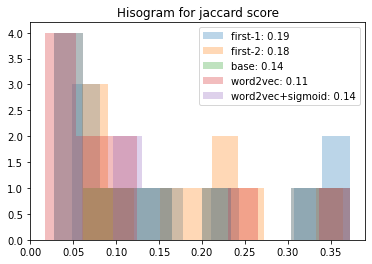

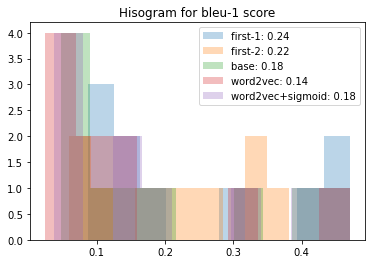

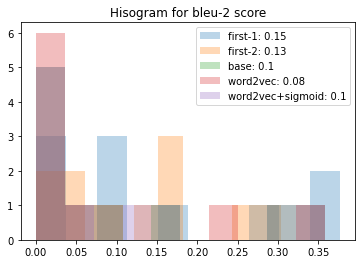

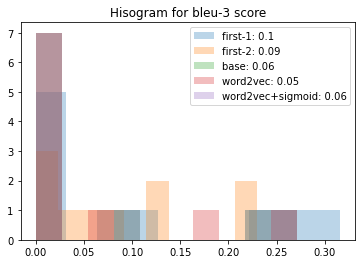

In [34]:
scores_table = compare_models(
    train = data,
    test = test,
    models = {
        'first-1': FirstKModel(STOP_WORDS, k=1),
        'first-2': FirstKModel(STOP_WORDS, k=2),
        'base': TextRankModel(STOP_WORDS),
        'word2vec': TextRankModel(STOP_WORDS,'word2vec'),
        'word2vec+weight': TextRankModel(STOP_WORDS,'word2vec', lambda x: pow(x,4)),

        
    },
    metrics = {
        'jaccard': (jaccard_score,),
        'bleu-1': (bleu, 1),
        'bleu-2': (bleu, 2),
        'bleu-3': (bleu, 3),
        # 'rouge-1': (rouge, 1),
        # 'rouge-2': (rouge, 2),
        # 'rouge-3': (rouge, 3),
        # 'rouge-L': (rouge, 'L'),
    },
    fit = False,
    plot = True
)

In [35]:
scores_table

,first-1,first-2,base,word2vec,word2vec+sigmoid
jaccard,0.19,0.18,0.14,0.11,0.14
bleu-1,0.24,0.22,0.18,0.14,0.18
bleu-2,0.15,0.13,0.10,0.08,0.10
bleu-3,0.10,0.09,0.06,0.05,0.06
